In [ ]:
ls /run/user/1000/gvfs/afp-volume:host=MyCloudPR4100.local,user=admin,volume=Paltas_DataBase/Data_Base/arbol_2_fila_G

In [1]:
DB="/run/user/1000/gvfs/afp-volume:host=MyCloudPR4100.local,user=admin,volume=Paltas_DataBase/Data_Base"

In [78]:
import os
#import skimage
import torch
import numpy as np
import glob
from skimage import io
import matplotlib.pyplot as plt

In [82]:
class Dataset_direct(torch.utils.data.Dataset):
    def __init__(self,root_dir,ImType=['PhantomRGB', 'SenteraRGB', 'SenteraNIR'],
                 days='*',
                 months='*',
                 Trees_col='*',
                 Trees_fil='*',
                 Intersec=False,
                 transform=None):
            """Data loader
            inputs:
            -root_dir(str): Directory that contains all the directories per tree
            -ImType(list of str): type of images to be used in posterior processing, ex: ['PhantomRGB', 'SenteraRGB', 'SenteraNIR']
            -days(list of integers): specific dates or '*' if date selection is no needed, ex: [13,19]
            -months(list of str):specific months or '*' if month selection is not needed, ex: ['junio','mayo']
            -Trees_col=(list of integers): specific numbers or '*' if date selection is no needed, ex: [13,19]
            -Trees_fil(list of str):specific rows or '*' if month selection is not needed, ex: ['A','C']
            -Intersec(bool):True if regular dataset in the selecter data types,
            -transform=None
            Outputs:

            Troubleshooting:
            -if number of NIR images and RGB images from sentera do not match
            """
            'Initialization'

            self.toID=np.vectorize(lambda d:("_").join(np.array((os.path.split(d)[1]).split("_"))[np.array([0,1,2,-3,-1])]))
            
            self.ImType=ImType
            
            Map_cols={'A':'N',
                    'B':'P',
                    'C':'K',
                    'D':'Control',
                    'E':'H50%',
                    'F':'H75%',
                    'G':'Control'}

            Map_fils=np.hstack((
                (np.arange(1,22)).reshape(3,-1).astype('object'),
                np.array([['Exceso'],['Control'],['Deficiencia']]).astype('object')
            ))
            
            self.DATA={
                'PhantomRGB':{
                    'data':np.array([]).astype('<U21'),
                    'ID':np.array([]).astype('<U21'),
                    'Place_label':np.array([]).astype('<U21'),
                    'Date':np.array([]).astype('<U21')
                },
                'SenteraRGB':{
                    'data':np.array([]).astype('<U21'),
                    'ID':np.array([]).astype('<U21'),
                    'Place_label':np.array([]).astype('<U21'),
                    'Date':np.array([]).astype('<U21')
                },
                'SenteraNIR':{
                    'data':np.array([]).astype('<U21'),
                    'ID':np.array([]).astype('<U21'),
                    'Place_label':np.array([]).astype('<U21'),
                    'Date':np.array([]).astype('<U21')
                }
            }
            
            for Type in ImType:
                data,ID=self.process_dirs(
                    root_dir=root_dir,
                    Type=Type,
                    days=days,
                    months=months,
                    Trees_col=Trees_col,
                    Trees_fil=Trees_fil
                )
                self.DATA[Type]['data']=data
                self.DATA[Type]['ID']=ID
            
            #Encontrar elementos existentes sin repeticion
            self.IDs=np.vectorize(lambda DATA,T:DATA[T]['ID'],otypes=[object],signature="(),()->()")(self.DATA,
                                                                                               np.array(ImType))
            
            uIDs=np.vectorize(lambda Id:np.unique(Id),otypes=[object])(self.IDs)
            self.aID=uIDs[0]
            
            #Encontrar elementos en comun
            for i in range(len(uIDs)-1):
                self.aID=np.union1d(uIDs[0],uIDs[1])
            #Only intersections
            if Intersec:
                
                uIDs=np.vectorize(lambda ID:np.unique(ID),otypes=[object])(self.IDs)
                inters=uIDs[0]
                for i in range(len(uIDs)-1):
                    inters=np.intersect1d(inters,uIDs[i+1])
            
                if inters.shape==(0,):
                    print("no hay elementos en común")
                else:
                    for Type in ImType:
                        whr=np.vectorize(lambda ID,selec: ID in selec,signature="(),(j)->()")(self.DATA[Type]['ID'],inters)
                        self.DATA[Type]['ID']=self.DATA[Type]['ID'][whr]
                        self.DATA[Type]['data']=self.DATA[Type]['data'][whr]
            
            #PROCESS LABELS
            
            for Type in ImType:
                #print(Type)
                #print(self.DATA[Type]['ID'][0])
                self.DATA[Type]['Place_label']=np.vectorize(self.get_labels)(self.DATA[Type]['ID'])
                self.DATA[Type]['Date']=np.vectorize(lambda iD: ("_").join((iD).split("_")[0:3]))(self.DATA[Type]['ID'])
                
            self.landmarks_frame_PRGB = self.DATA['PhantomRGB']['data']
            self.landmarks_frame_SRGB = self.DATA['SenteraRGB']['data']
            self.landmarks_frame_SNIR = self.DATA['SenteraNIR']['data']
                
            self.transform = transform

    def __len__(self):
        #return len(self.landmarks_frame_PRGB),len(self.landmarks_frame_SRGB),len(self.landmarks_frame_SNIR)
        return len(self.landmarks_frame_PRGB)

    def __getitem__(self, idx):
            'Generates one sample of data'
            # Select sample
            if torch.is_tensor(idx):
                  idx=idx.tolist()

            idxID=self.aID[idx]
            images_dir=np.vectorize(lambda data,TT,idx:data[TT]["data"][data[TT]["ID"]==idx],
                                    otypes=[object],
                                    signature="(),(),()->()")(self.DATA,np.array(self.ImType),idxID)
            
            landmarks=np.vectorize(lambda data,TT,idx:data[TT]["Place_label"][data[TT]["ID"]==idx],
                                    otypes=[object],
                                    signature="(),(),()->()")(self.DATA,np.array(self.ImType),idxID)
            
            #image = io.imread(img_name)
            images=np.vectorize(self.special_imread,otypes=[object])(images_dir)

            
            sample = {'imagePRGB': images[0],
                      'imageSRGB': images[1],
                      'imageSNIR': images[2],
                      'landmarks': landmarks[0][0]}
            if self.transform:
                  sample=self.transform(sample)

            return sample
            

    def special_imread(self,im):
        if im.shape!=(0,):
            oim=io.imread(im[0])
        else:
            oim=np.array([[0]])
        return oim

    def process_dirs(self,root_dir,months,days,Trees_col,Trees_fil,Type):
        data=np.vectorize(lambda days,mth,Trees_col:glob.glob(os.path.join(root_dir,"*/"+
                                                            Type+"/"+
                                                            str(days)+"_"+
                                                            mth+"_*__arbol_"+
                                                            str(Trees_col)+"_fila_"+
                                                            str(Trees_fil)+
                                                            ".*")),
                                   signature="(),(),()->()",
                                   otypes=[object])(
            np.array(days),
            np.array(months),
            np.array(Trees_col)
        )
        
        if days!='*' or months!='*' or Trees_col!='*':
            data=np.concatenate(data)
        else:
            data=np.array(data.reshape(1,)[0])
        if data.shape!=(0,):
            ID=self.toID(data)
        else:
            ID=np.array([])
        return data,ID
        
    
    def get_labels(self,IDs):
        Map_cols={'A':'N','B':'P','C':'K',
                  'D':'Control','E':'H50%','F':'H75%','G':'Control'}
        Map_fils=np.hstack(((np.arange(1,22)).reshape(3,-1).astype('object'),
                        np.array([['Exceso'],['Control'],['Deficiencia']]).astype('object')))
        Type=Map_cols[IDs.split('.')[0].split("_")[-1]]
        Num=int(IDs.split('.')[0].split("_")[-2])
        if Type in ['N','P','K']:
            Suf=Map_fils[np.vectorize(lambda ran,n:n in ran,signature="(j),()->()")(Map_fils[:,:-1],Num),-1]
            Type=(Type+"_"+Suf)[0]
        return Type



In [83]:
datab=Dataset_direct(root_dir=DB,ImType=['PhantomRGB', 'SenteraRGB','SenteraNIR'],
                 #days=[13,19],
                 #months='*',
                     #months=['junio','mayo'],
                     #months=['agosto'],
                 #Trees_col='*',
                    # Trees_col=[12,14],
                 Trees_fil='*',
                     Intersec=False,
                 transform=None)

In [47]:
a=90
idxID=datab.aID[a]
#idxID=datab.DATA["SenteraRGB"]['ID'][0]
#print(idxID)
#ImType=np.array(['PhantomRGB', 'SenteraRGB','SenteraNIR'])
#print(datab.DATA["PhantomRGB"]["data"][datab.DATA["PhantomRGB"]["ID"]==idxID])
#a=np.vectorize(lambda data,TT,idx:data[TT]["data"][data[TT]["ID"]==idx],otypes=[object],signature="(),(),()->()")(datab.DATA,ImType,idxID)

15_setiembre_1_1_A.JPG
[]


In [84]:
datab[0]

{'imagePRGB': array([[[44, 39, 35],
         [44, 39, 35],
         [46, 41, 37],
         ...,
         [25, 24, 20],
         [25, 24, 20],
         [25, 24, 20]],
 
        [[50, 45, 41],
         [49, 44, 40],
         [49, 44, 40],
         ...,
         [24, 23, 19],
         [25, 24, 20],
         [25, 24, 20]],
 
        [[56, 51, 47],
         [53, 48, 44],
         [52, 47, 43],
         ...,
         [24, 23, 19],
         [24, 23, 19],
         [25, 24, 20]],
 
        ...,
 
        [[68, 61, 55],
         [66, 59, 53],
         [69, 62, 56],
         ...,
         [72, 69, 62],
         [64, 61, 54],
         [58, 55, 48]],
 
        [[69, 62, 56],
         [70, 63, 57],
         [72, 65, 59],
         ...,
         [75, 72, 65],
         [74, 71, 64],
         [73, 70, 63]],
 
        [[71, 64, 58],
         [71, 64, 58],
         [72, 65, 59],
         ...,
         [78, 75, 68],
         [84, 81, 74],
         [87, 84, 77]]], dtype=uint8),
 'imageSRGB': array([[0]]),
 

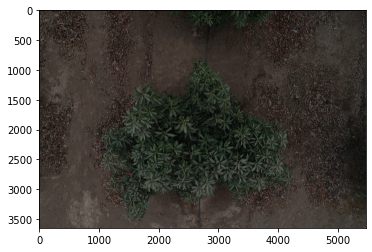

In [79]:
plt.imshow(datab[0]['imagePRGB'])

In [86]:
Map_fils=np.hstack((
                (np.arange(1,22)).reshape(3,-1).astype('object'),
                np.array([['Exceso'],['Control'],['Deficiencia']]).astype('object')
            ))
Map_fils

array([[1, 2, 3, 4, 5, 6, 7, 'Exceso'],
       [8, 9, 10, 11, 12, 13, 14, 'Control'],
       [15, 16, 17, 18, 19, 20, 21, 'Deficiencia']], dtype=object)